# Course Project No 3 - Part 2 - House prices

Let's import all the base libraries that we will use in this Notebook

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Goal of this second part

Estimate the price of 500 houses using a model based on 2'430 house prices, analyzing a dataset made of 82 features

## A quick look at the data

In [12]:
data_df = pd.read_csv(os.path.join('data','house-prices.csv'))
data_df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000


## Data cleaning

Data in this set is not optimal and has to be cleaned before being used. Here is the methodology followed.


### Drop useless columns

Order and PID columns are useless to fit models. Drop it :-)

In [13]:
data_df.drop(['Order', 'PID'], axis=1, inplace=True)

### Remove columns with more than 20% empty cells
Some of the columns contains a huge amount of null cells, we should drop them as they won't be pertinent to build our model.
Choice has been done to drop columns where number of null cells represent more than 20% of total cells

In [14]:
# Number of lines in dataset
total_cell = data_df.shape[0]

# NULL_CELL_LIMIT is the max allowed percentage of null value in a column
NULL_CELL_LIMIT = 0.20

# List of columns that we will drop
columns_to_drop = list()

# Loop in each column and identify the one to drop
for c in data_df.columns:
    no_of_null_cell = data_df[c].isnull().sum()
    if(no_of_null_cell/total_cell > NULL_CELL_LIMIT):
        columns_to_drop.append(c)

print("Columns to drop:", ','.join(columns_to_drop))
# Drop identified columns
data_df.drop(columns_to_drop, axis=1, inplace=True)


Columns to drop: Alley,Fireplace Qu,Pool QC,Fence,Misc Feature


### Remove lines with empty cells on columns with a few empty values

Some of the remaining column after this first cleaning still contains empty cells. Decision is made to drop all the lines that contains null values in the columns where the total number of null values in those columns is not null and lower than a fixed value.

To evaluate the fixed value, we will try different one and maesure how much line will be dropped. If the result is less the 20%, then it's a good choice. 20% of the test dataframe represents around 80% of the test dataset, which is an acceptable factor.


In [16]:
# Sum number of empty cells per column
null_sum_df = data_df.isnull().sum().to_frame()

# A dictionnary that will contain the different dataframe
data_df_list = dict()

for i in (10, 100, 200, 300, 400, 500):
    columns_df = null_sum_df[np.logical_and(null_sum_df[0] > 0, null_sum_df[0] < i)]
    bool_filter = data_df[columns_df.index.values.tolist()].isnull().values.any(axis=1)
    data_df_list[i] = data_df[np.logical_not(bool_filter)]
    df_size = data_df_list[i].shape[0]
    print("Resulting size of the Dataframe (factor = {:3}) = {}/{} (ratio = {:.2f}%)".format(i,df_size,data_df.shape[0],(df_size/data_df.shape[0])*100))


Resulting size of the Dataframe (factor =  10) = 2426/2430 (ratio = 99.84%)
Resulting size of the Dataframe (factor = 100) = 2333/2430 (ratio = 96.01%)
Resulting size of the Dataframe (factor = 200) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 300) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 400) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 500) = 1815/2430 (ratio = 74.69%)


According to our previous test, if we drop all the lines where, in the corresponding columns, the number of empty cells are not null and below 400, we do remove around 200 lines, which is acceptable. Our dataframe should now take the value data_df_list[400].

And finally, we remain with only one column containing null values: Lot Frontage

In [17]:
data_df = data_df_list[400].copy()

# Display columns with empty values, sorted descending
data_df.isnull().sum().to_frame().sort_values(0, ascending = False).head(3)

,0
Lot Frontage,394
MS SubClass,0
Full Bath,0


Let's have a look at thisd column to determine what to do with empty cells.

Best option at that time, draw an histogram graph:

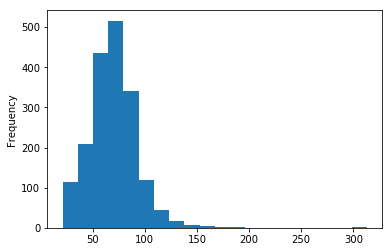

In [18]:
data_df['Lot Frontage'].plot.hist(bins=20)
plt.show()

Previous graph shows that we have some outliers in this columns, and most of the datapoints are centered on a value around 60.

The approach we can choose to handle null values in this column is to replace them by the mean value of the column, without the outliers and null values. See below the new histogram and the mean value calculated. This value will be used to replace null values in that column.

Mean value calculated with the reduced dataset: 68.79


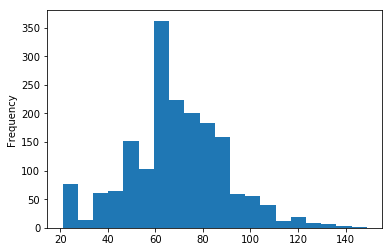

In [19]:
data_df['Lot Frontage'][np.logical_and(data_df['Lot Frontage'] < 150, data_df['Lot Frontage'] > 0)].plot.hist(bins=20)
mean_value = data_df['Lot Frontage'][np.logical_and(data_df['Lot Frontage'] < 150, data_df['Lot Frontage'] > 0)].mean()
print("Mean value calculated with the reduced dataset: {:.2f}".format(mean_value))



In [28]:
data_df['Lot Frontage Clean'] = data_df['Lot Frontage'].fillna(int(mean_value))

# do not forget to drop the orignal column
data_df = data_df.drop('Lot Frontage', axis=1)

print("Number of null value in dataframe:", data_df.isnull().sum().sum())
print("Dataframe size:", data_df.shape)
print("Good :-)")


Number of null value in dataframe: 0
Dataframe size: (2209, 75)
Good :-)


Fine. Our dataset has now 0 null values. It's time now to identify any outliers.

We will concentrate on numeric columns as it makes no sense to search outliers on the other ones.


In [68]:
data_df.head(2)

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Lot Frontage Clean
0,60,RL,8795,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,0,0,0,0,4,2009,WD,Normal,236000,68.0
1,20,RL,10170,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,6,2006,WD,Normal,155000,75.0


In [69]:
for c in data_df.select_dtypes(np.number):
    c_mean = data_df[c].mean()
    c_std  = data_df[c].std()
    z_min  = (c_mean-data_df[c].min())/c_std
    z_max  = (data_df[c].max()-c_mean)/c_std
    outliers = ''
    if (z_min > 2 or z_max > 2):
        outliers = '(outliers)'
    print("Column {:20s} mean:{:9.2f}\tstd:{:9.2f}\tz-min:{:9.2f}\tz-max:{:10.2f} {}".format(c, c_mean, c_std, z_min, z_max, outliers))
    

Column MS SubClass          mean:    56.25	std:    41.91	z-min:     0.87	z-max:      3.19 (outliers)
Column Lot Area             mean: 10340.81	std:  8582.74	z-min:     1.03	z-max:     23.87 (outliers)
Column Overall Qual         mean:     6.22	std:     1.36	z-min:     3.11	z-max:      2.79 (outliers)
Column Overall Cond         mean:     5.59	std:     1.07	z-min:     4.30	z-max:      3.19 (outliers)
Column Year Built           mean:  1972.89	std:    29.45	z-min:     3.19	z-max:      1.26 (outliers)
Column Year Remod/Add       mean:  1984.95	std:    20.37	z-min:     1.72	z-max:      1.23 
Column Mas Vnr Area         mean:   109.30	std:   181.49	z-min:     0.60	z-max:      8.21 (outliers)
Column BsmtFin SF 1         mean:   469.81	std:   459.93	z-min:     1.02	z-max:     11.25 (outliers)
Column BsmtFin SF 2         mean:    55.04	std:   178.74	z-min:     0.31	z-max:      8.23 (outliers)
Column Bsmt Unf SF          mean:   569.30	std:   436.84	z-min:     1.30	z-max:      4.04 (outliers)


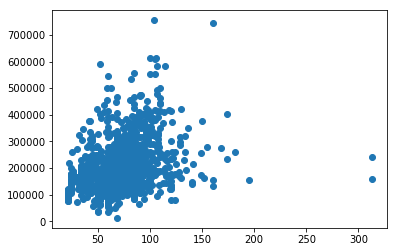

In [87]:
data_df['Lot Area'].sort_values(ascending=False)
plt.scatter(data_df['Lot Frontage Clean'], data_df['SalePrice'])

## Feature encoding

> Question: What is the difference between feature encoding and feature engineering ?

## Feature engineering

## Model fitting

## Regularization

## Communicating the results

## Compute predictions

## Evaluate your predictions